<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/main/template-report-Stokes-AMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations - adaptive mesh refinement**
**Emil Gestsson, using template by Johan Hoffman**

# **Abstract**

Lab 3 was solved, including extra assignment 1.
[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [2]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The template code has been combined into a big function that makes it easy to generate the needed graphs and data for the assignment.

Question 1 can be solved by generating a set of adjoint solutions and refined meshes for different cylinder positions, followed by an analysis of the results.

Question 2 can be solved by generating a set of adjoint solutions and refined meshes for different choices of $\phi_1, \phi_2, \phi_3$, followed by an analysis of the results.


Extra assignment 1 is solved by first comparing the total error with and without equal function spaces for primal and adjoint equaitons. This will show that different polynomials are required for a correct error approximation. We can then use the refined mesh as a starting point and compute new error approximations, which should be smaller than with an unrefined grid.

The extra assigment was implemented by adding a fix_error flag, which simply increases the polynomial degree of the adjoint function space by 1, as well as a mesh parameter which will be used instead of creating a new mesh.

# **Method**

**Template combined into a big function that returns a refined mesh, primal solutions, adjoint solutions, and total error.**

In [4]:
# Define rectangular domain
L = 4
H = 4

# Define circle
xc = 0.5
yc = 0.5*H
rc = 0.2
def create_solution(xc = 0.5, yc = 2, psi1_e = ("0.0","0.0"), psi2_e = "0.0", psi3_e = ("1.0","0.0"), mesh = None, fix_error = False):
  # Generate mesh (examples with and without a hole in the mesh)
  resolution = 32

  if mesh is None:
    mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

    # Local mesh refinement (specified by a cell marker)
    init_no_levels = 0
    for i in range(0,init_no_levels):
      cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
      for cell in cells(mesh):
        cell_marker[cell] = False
        p = cell.midpoint()
        if p.distance(Point(0.5, 0.5)) < 1.0:
            cell_marker[cell] = True
      mesh = refine(mesh, cell_marker)

  ### Define finite element approximation spaces

  # Generate mixed finite element spaces (for primal velocity and pressure)
  VE = VectorElement("CG", mesh.ufl_cell(), 2)
  QE = FiniteElement("CG", mesh.ufl_cell(), 1)
  WE = VE * QE

  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)

  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W)

  # Generate mixed finite element spaces (for adjoint velocity and pressure)
  VEa = VectorElement("CG", mesh.ufl_cell(), 3 if fix_error else 2)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 2 if fix_error else 1)
  WEa = VEa * QEa

  Wa = FunctionSpace(mesh, WEa)
  Va = FunctionSpace(mesh, VEa)
  Qa = FunctionSpace(mesh, QEa)

  # Define adjoint trial and test functions
  wa = Function(Wa)
  (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
  (va, qa) = TestFunctions(Wa)

  #### Define boundary conditions

  # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
  #pout = 0.0

  # Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
  wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
  bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

  #### Define and solve variational problems

  # Set boundary penalty parameter gamma
  h = CellDiameter(mesh)
  C = 1.0e3
  gamma = C/h

  # Set force in primal problem
  f = Expression(("0.0","0.0"), element = V.ufl_element())

  # Set data that describe functional that defines the adjoint problem
  #psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
  #psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
  psi1 = Expression(psi1_e, element = V.ufl_element())
  psi2 = Expression(psi2_e, element = Q.ufl_element())
  phi3 = Expression(psi3_e, element = V.ufl_element())

  # Define primal variational problem on residual form: r(u,p;v,q) = 0
  res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx +
          gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

  # Solve primal algebraic system
  solve(res == 0, w)

  # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
  res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx +
            gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds
          - inner(va, psi1)*dx - qa*psi2*dx )

  # Solve adjoint algebraic system
  solve(res_a == 0, wa)

  # Initiate functions to save and visualize the solutions
  u_fcn = project(u, V)
  p_fcn = project(p, Q)
  phi_fcn = project(phi, V)
  theta_fcn = project(theta, Q)

  #### Compute error indicators

  # Define function space over the elements of the mesh
  WDG = FunctionSpace(W.mesh(), "DG", 0)
  elm = TestFunction(WDG)
  err_ind = Function(WDG)

  # Compute local error indicators over the cells of the mesh
  local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx )
  err_ind.vector()[:] = assemble(local_error)
  err_ind_abs = np.abs(err_ind.vector())
  err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

  # Local mesh refinement (specified by a cell marker)
  no_levels = 1
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for c in cells(mesh):
      cell_marker[c] = False
      local_error_cell = err_ind_abs[c.index()]
      if local_error_cell > err_ind_mean:
          cell_marker[c] = True
    mesh = refine(mesh, cell_marker)

  err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx -
                gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

  tot_err = assemble(err_ind_sum)
  return mesh, u_fcn, p_fcn, phi_fcn, theta_fcn, tot_err



# **Results**

## **Question 1**

**Create Adjoint Solutions and Refined Meshes for a set of points**

In [ ]:
points = [(0.5, 2), (2, 2), (3, 3), (3.5, 3.5)]
meshes, phis, thetas = [], [], []

for (xc, yc) in points:
  mesh, _, _, phi_fcn, theta_fcn, _ = create_solution(xc, yc)
  meshes.append(mesh)
  phis.append(phi_fcn)
  thetas.append(theta_fcn)


**Plot Adjoint Solutions and Refined Meshes for Question 1**

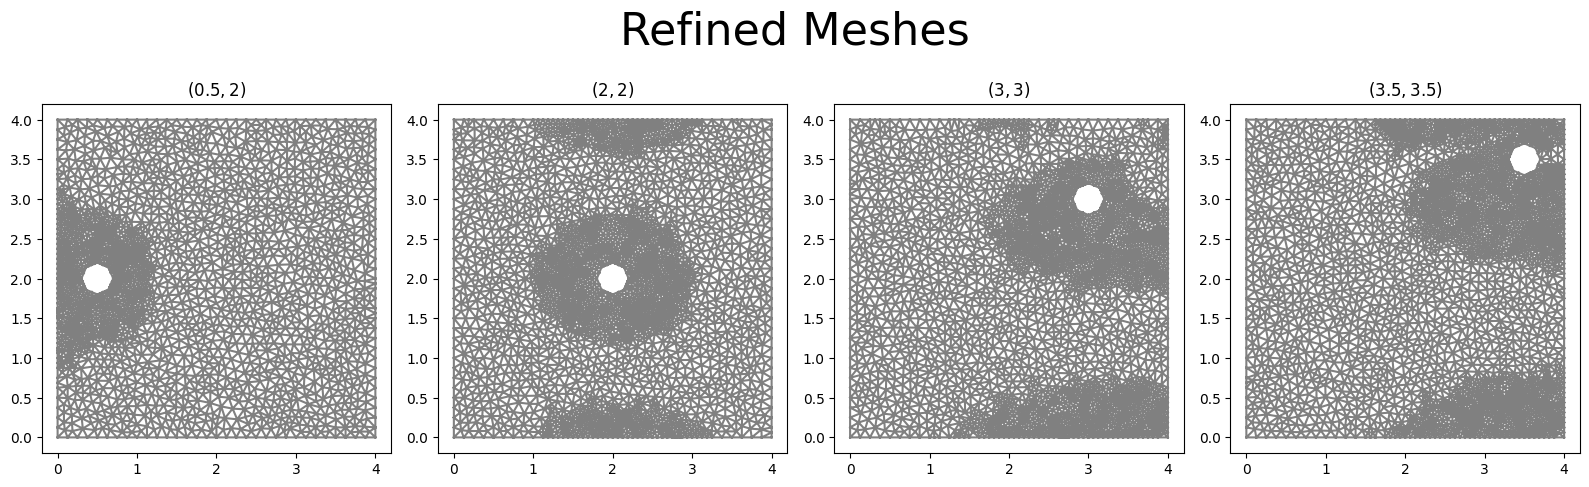

<Figure size 640x480 with 0 Axes>

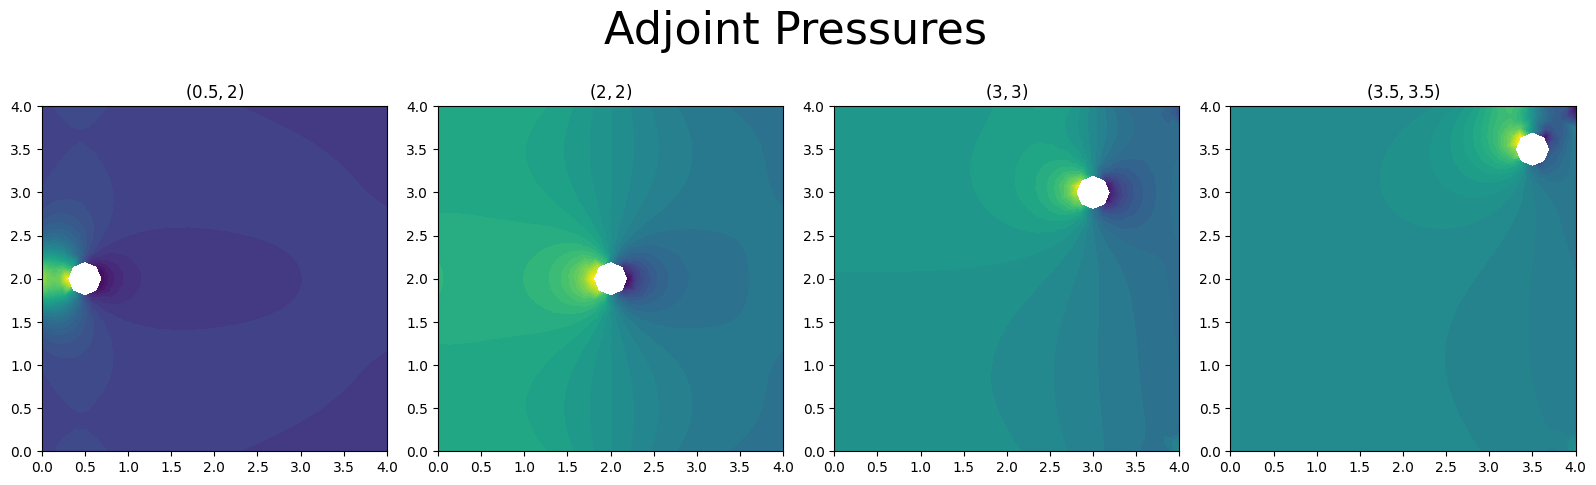

<Figure size 640x480 with 0 Axes>

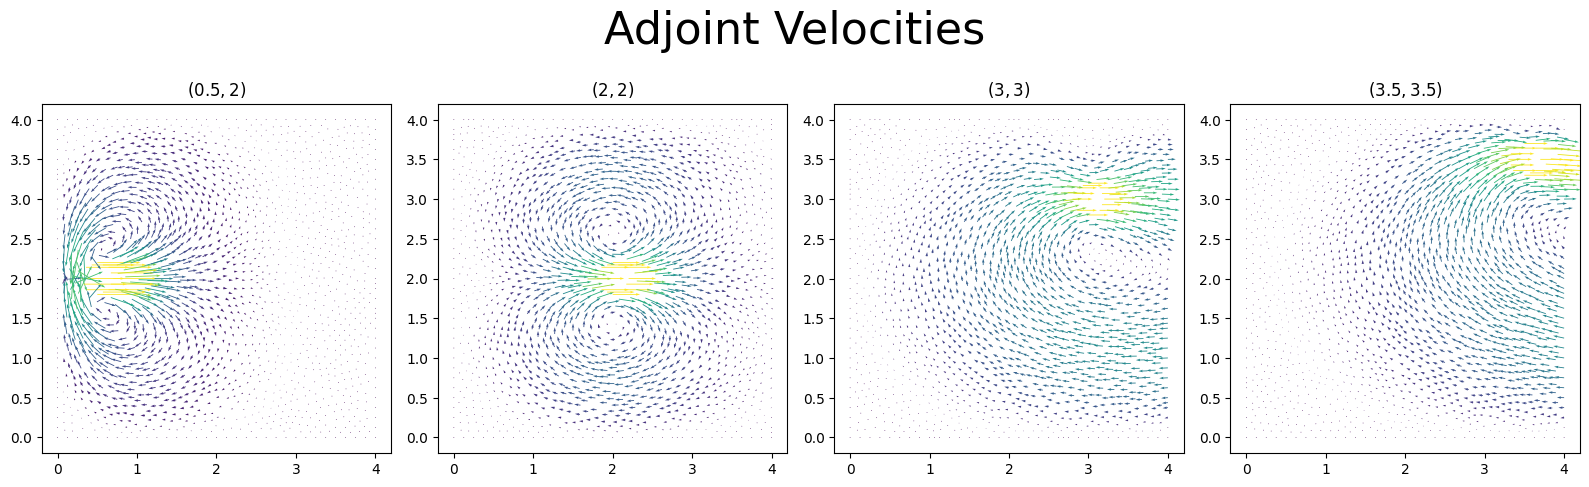

In [6]:
plt.subplots(1, len(points), figsize=(4 * len(points), 5), tight_layout=True)
for i, (m, (xc, yc)) in enumerate(zip(meshes, points)):
  plt.subplot(1, len(points), i + 1)
  plot(m, title=f"(${xc}, ${yc})")

plt.suptitle("Refined Meshes", fontsize=32);

plt.figure()
plt.subplots(1, len(points), figsize=(4 * len(points), 5), tight_layout=True)
for i, (t, (xc, yc)) in enumerate(zip(thetas, points)):
  plt.subplot(1, len(points), i + 1)
  plot(t, title=f"(${xc}, ${yc})")

plt.suptitle("Adjoint Pressures", fontsize=32);

plt.figure()
plt.subplots(1, len(points), figsize=(4 * len(points), 5), tight_layout=True)
for i, (p, (xc, yc)) in enumerate(zip(phis, points)):
  plt.subplot(1, len(points), i + 1)
  plot(p, title=f"(${xc}, ${yc})")

plt.suptitle("Adjoint Velocities", fontsize=32);
plt.show()

Among the different refined meshes we see that the regions with large errors are generally not limited to a single region, but usually split into 2 or more "blobs". The blobs becomes less circular as it gets close to the right boundary, and whenever its close to the left boundary there were no extra blobs. This likely indicates that the error is more localized the closer the cylinder is to the left boundary.

We can see something similar to this in the adjoint pressure, whenever the cylinder is near the left and right bounds, the pressure differences gets larger.

The velocity graphs are quite uneventful apart from the fact that two vortexes appear.

## **Question 2**

I am using 4 simple examples where only a single $\psi$ variable is set at a time, and in a simple direction/value. This will correspond to a linear functional which represents an unweighted average across domains for said variable.

I am unsure how to intepret the adjoint solutions with respect each chosen functional, as unlike with discrete adjoint representations where the solutions are explicit terms of an inverse (which creates an immediate interpretation of sensitivity), my understanding is that the continious adjoint equations only provide legible and consistent information of the primal solution through manipulations of the dual form.

Since the only thing we are explicitly calculating/using is the residuals w.r.t the functional generated by $F(v, q)$, the only conclution I will draw from the adjoint equations is that the refined areas are where the most error to the functional occurs.

This also means we can attach meaning to the functional, as for instance, when setting $\psi_3 = (1, 0)$, which represents the total force in the x direction, we can see which regions induces the largest errors in the computation of drag. Notably, they represent a weighted average of velocity ($\psi_1$), pressure ($\psi_2$) and force on the boundary ($\psi_3$).

Here are the adjoint solutions and refined meshes, along with what their functional represents:

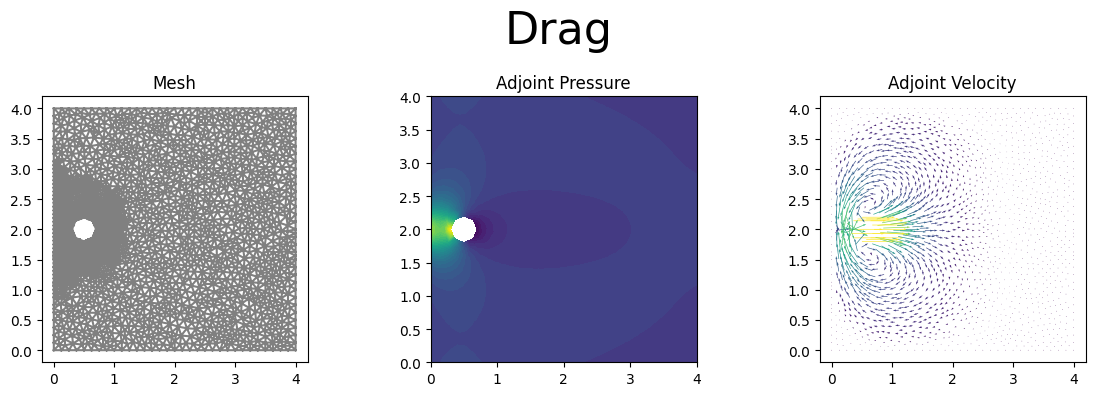

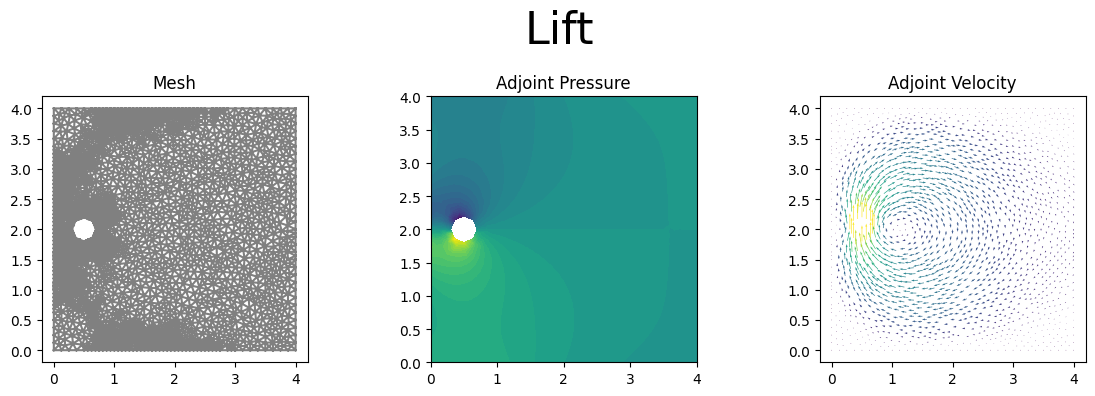

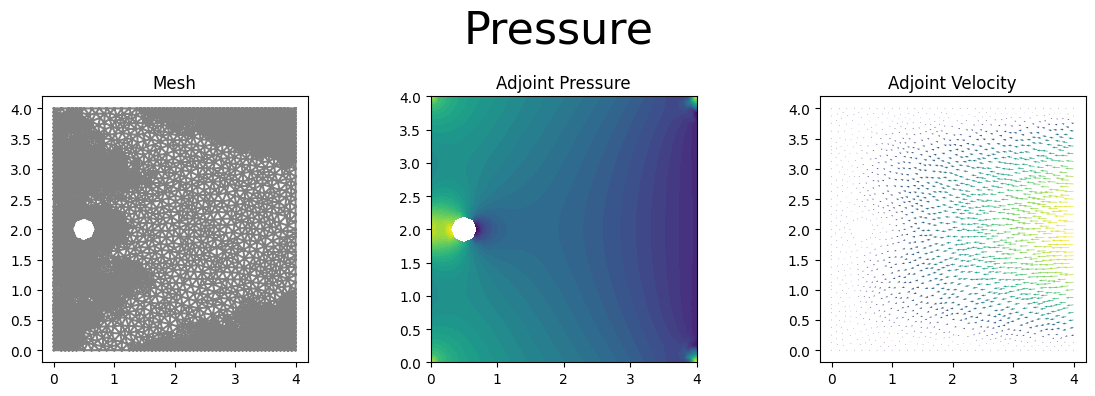

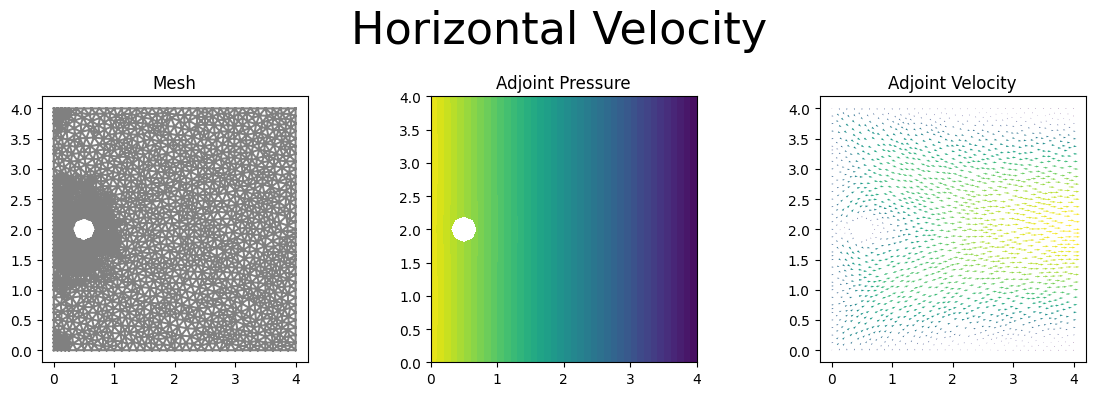

In [7]:
psis= [(("0.0","0.0"), "0.0", ("1.0","0.0"), "Drag"),
       (("0.0","0.0"), "0.0", ("0.0","1.0"), "Lift"),
       (("0.0","0.0"), "1.0", ("0.0","0.0"), "Pressure"),
       (("1.0","0.0"), "0.0", ("0.0","0.0"), "Horizontal Velocity")]

for (p1, p2, p3, name) in psis:
  mesh, _, _, phi_fcn, theta_fcn, _ = create_solution(0.5, 2, p1, p2, p3)

  plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
  plt.subplot(1, 3, 1)
  plot(mesh, title=f"Mesh")
  plt.subplot(1, 3, 2)
  plot(theta_fcn, title=f"Adjoint Pressure")
  plt.subplot(1, 3, 3)
  plot(phi_fcn, title=f"Adjoint Velocity")

  plt.suptitle(name, fontsize = 32);


We can see that the regions important for drag and horizontal velocity is mostly the same, except that horizontal force has refined a region near the top and bottom of the left boundary. The large errors in lift occurs along the lines pushed aside by the cylinder. Since the error inducing area for pressure is so large, we know that the differences in error are likely more uniform (since more of the area is greater than the mean).

## **Extra Question 1**



Here are two total errors using equal and different function spaces for the adjoint and primal equations:

In [10]:
_, _, _, _, _, tot_error1 = create_solution(fix_error=False)
_, _, _, _, _, tot_error2 = create_solution(fix_error=True)
print(f"Approximate error without same degree:   {tot_error1}")
print(f"Approximate error with different degree: {tot_error2}")

Approximate error without same degree:   -2.0248478458176344e-13
Approximate error with different degree: 0.050622244947699326


We can see that the approximate error when using the same polynomials is practically zero, and that using differing polynomials gives a reasonable error estimate.

We can now compare errors with and without a refined mesh:

In [9]:
refined_mesh, _, _, _, _, error_before = create_solution(fix_error=True)
_, _, _, _, _, error_after = create_solution(mesh=refined_mesh, fix_error=True)

print(f"Error without refined mesh: {error_before}")
print(f"Error using refined mesh: {error_after}")

Error without refined mesh: 0.050622244947699326
Error using refined mesh: 0.022778656718950963


Which shows that the approximate error was decreased by half when using a refined mesh.

# **Discussion**